<a href="https://colab.research.google.com/github/Sharma117555448/Test-Commit-Project-3-B/blob/main/sharma_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds

print("Tensorflow version:", tf.__version__)
print("# GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print(tf.test.is_gpu_available())

Tensorflow version: 2.4.1
# GPUs Available:  1
True


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
Fish_Dataset/
  Gilt-Head Bream/
    Gilt-Head Bream/
    Gilt-Head Bream GT/
  Red Sea Bream/
    Red Sea Bream/
    Red Sea Bream GT/
  Sea Bass/
    Sea Bass/
    Sea Bass GT/


'Fish_Dataset/\n  Gilt-Head Bream/\n    Gilt-Head Bream/\n    Gilt-Head Bream GT/\n  Red Sea Bream/\n    Red Sea Bream/\n    Red Sea Bream GT/\n  Sea Bass/\n    Sea Bass/\n    Sea Bass GT/'

In [ ]:
import pathlib
data_dir = "/content/drive/MyDrive/Fish_Dataset"
DATADIR = "/content/drive/MyDrive/Fish_Dataset"

import numpy as np
import matplotlib.pyplot as plt
import os
import cv2

DATADIR = "/content/drive/MyDrive/Fish_Dataset"
CATEGORIES = ["Gilt-Head Bream", "Red Sea Bream", "Sea Bass", 
              "Red Mullet", "Hourse Mackerel", "Black Sea Sprat", 
              "Striped Red Mullet", "Trout", "Shrimp"]
 
for category in CATEGORIES:
  path = os.path.join(DATADIR, category)
  for GT in os.listdir(path):
    pathGT = os.path.join(path, GT)
    for img in os.listdir(pathGT):
      img_array = cv2.imread(os.path.join(pathGT,img), cv2.IMREAD_GRAYSCALE)

In [14]:
batch_size = 64
img_height = 180
img_width = 180


In [15]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)


Found 18000 files belonging to 9 classes.
Using 14400 files for training.


In [16]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)


Found 18000 files belonging to 9 classes.
Using 3600 files for validation.


In [18]:
print("Class names")
class_names = train_ds.class_names
print(class_names)

Class names
['Black Sea Sprat', 'Gilt-Head Bream', 'Hourse Mackerel', 'Red Mullet', 'Red Sea Bream', 'Sea Bass', 'Shrimp', 'Striped Red Mullet', 'Trout']


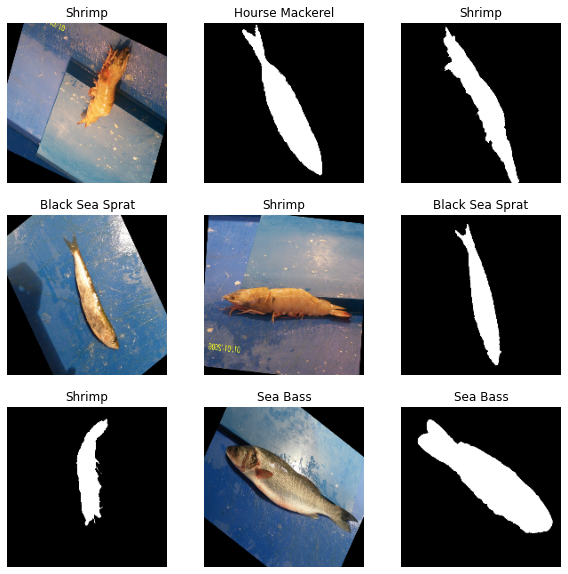

In [19]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")


In [20]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break


(64, 180, 180, 3)
(64,)


In [21]:
from tensorflow.keras import layers

normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)


In [22]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))


0.0 1.0


In [23]:
# Prepare data and keeps in memory
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)


In [24]:
num_classes = 9

# Create model for CNN
model = tf.keras.Sequential([
  # Rescale to [-1, 1]
  layers.experimental.preprocessing.Rescaling(1./127.5, offset=-1),
  layers.Conv2D(64, (3,3), activation='relu', padding="same"),
  layers.Conv2D(64, (3,3), activation='relu', padding="same"),
  layers.MaxPooling2D(pool_size=(2,2),strides=(2,2)),

  layers.Conv2D(128, (3, 3), activation='relu', padding="same"),
  layers.Conv2D(128, (3, 3), activation='relu', padding="same"),
  layers.MaxPooling2D(pool_size=(2,2),strides=(2,2)),

  layers.Conv2D(256, (3, 3), activation='relu', padding="same"),
  layers.Conv2D(256, (3, 3), activation='relu', padding="same"),
  layers.Conv2D(256, (3, 3), activation='relu', padding="same"),
  layers.MaxPooling2D(pool_size=(2,2),strides=(2,2)),

  layers.Flatten(),
  layers.Dense(4096, activation='relu'),
  layers.Dense(4096, activation='relu'),
  layers.Dense(num_classes, activation = 'softmax')
])


In [25]:
# Compile model
model.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])


In [ ]:
# Fit model (train it)
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=3,
  verbose = 1
)


Epoch 1/3
  1/225 [..............................] - ETA: 4:28:33 - loss: 2.1995 - accuracy: 0.0625

In [74]:
#history = model.fit(train_ds, validation_data=val_ds, epochs=3)
#history = model.fit(train_generator, epochs=50, steps_per_epoch=781, 
                    #validation_data = validation_generator, verbose = 1, callbacks=[callback])

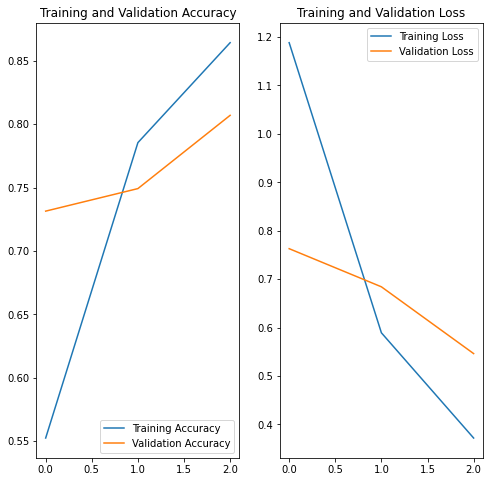

In [104]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(3)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')

plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [105]:
model.save('fishes.model')

INFO:tensorflow:Assets written to: fishes.model/assets


In [106]:
new_model = tf.keras.models.load_model('fishes.model')

In [108]:
img_batch = np.expand_dims(val_ds, axis=0)


In [ ]:
img_preprocessed = preprocess_input(img_batch)

In [109]:
predictions = new_model.predict(val_ds)

In [111]:
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions

#print(decode_predictions(predictions, top=3)[0])
print(predictions)

[[5.7509265e-13 9.9312371e-01 2.5585798e-05 ... 3.6287542e-12
  1.6220236e-10 1.0166792e-03]
 [1.7537428e-19 3.1140728e-03 3.3111687e-09 ... 9.3481587e-20
  2.4308013e-13 9.3085918e-04]
 [2.4454258e-04 3.8032983e-06 2.6764499e-04 ... 1.8157425e-06
  1.4905995e-04 6.9070431e-08]
 ...
 [1.7703174e-08 2.9503352e-03 2.5993533e-04 ... 6.5920769e-10
  5.1605648e-06 6.3930190e-01]
 [2.1285578e-09 2.7919580e-07 1.9983351e-07 ... 3.5265530e-05
  8.3955109e-07 3.0711125e-11]
 [1.9811318e-14 8.9696117e-02 9.9233803e-06 ... 4.9370152e-12
  9.5287662e-09 4.9614683e-03]]


In [112]:
print(np.argmax(predictions[4]))

6


In [117]:
plt.imshow(val_ds[4],cmap=plt.cm.binary)
plt.show()